In [1]:
import pickle
import faiss 
import torch
import numpy as np
import math
from asif import extract_candidate_sets_from_clusters
import random
from tqdm import tqdm
from matplotlib import pyplot as plt
import sklearn
from operator import itemgetter 
from typing import Tuple, List, Type, Union

In [8]:
def standardize(tensor):
    means = tensor.mean(dim=1, keepdim=True)
    stds = tensor.std(dim=1, keepdim=True)
    return (tensor - means) / stds

def compute_relative_coordinates(embeddings, anchors, k, p=7):

    embeddings = standardize(embeddings)
    anchors = standardize(anchors)
                
    sim = (1 / (1 + torch.cdist(embeddings, anchors)))
    
    result = torch.zeros(sim.size())
        
    for i, j in enumerate(torch.argsort(sim, descending=True)[:,:k]):
        result[i][j] = p
    
    return torch.nn.functional.normalize(result)

def evaluate_asif(relative_coordinates_1, relative_coordinates_2, n_of_samples):
    distances_1_to_2 = 1 / (1 + torch.cdist(relative_coordinates_1, relative_coordinates_2))

    # Get the max similarity for each vecotry in relative_coordinates_1
    max_values = distances_1_to_2.max(dim=1, keepdim=True)
    correct = 0

    for sample_index in range(n_of_samples):
        
        # Get indexes of elements with max similarity
        indexes = (distances_1_to_2[sample_index] == max_values.values[sample_index]).nonzero(as_tuple=True)[0]
        

        # Check if the index of the current element is among the elements with the maximum similarity
        if indexes.__contains__(sample_index):
            correct = correct + 1

        #retrieved_elements = itemgetter(*indexes)(elements_2)
        #if elements_2[sample_index] in retrieved_elements:
        #    correct = correct + 1
    
    return correct, int((correct/n_of_samples)*100)


def elbow(X, cluster_sizes, label = "Elbow curve"):
    distorsions = []
    result = {}
    for k in tqdm(cluster_sizes):
        kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=k)
        kmeans.fit(X)
        distorsions.append(kmeans.inertia_)
        result[k] = kmeans
    fig = plt.figure(figsize=(15, 5))
    plt.plot(cluster_sizes, distorsions)
    plt.xticks(cluster_sizes)
    plt.grid(True)
    plt.title(label)
    return result

In [3]:
data_folder = "data"
computing_device = "cuda:0"

In [4]:
print("Loading dataset...")
lyrics = pickle.load(open(f"{data_folder}/lyrics.pkl", "rb"))
chords = pickle.load(open(f"{data_folder}/chords.pkl", "rb"))
artist_song = pickle.load(open(f"{data_folder}/artist_song.pkl", "rb"))


lyrics_embeddings = pickle.load(open(f"{data_folder}/lyrics_embeddings_sbert_roberta.pkl", "rb"))
chords_embeddings = pickle.load(open(f"{data_folder}/chords_embeddings_sbert_chocolm.pkl", "rb"))

Loading dataset...


In [5]:
n_of_samples = 10_000

sample = np.random.choice(np.intersect1d(np.unique(chords, return_index=True)[1], np.unique(lyrics, return_index=True)[1]), n_of_samples)

chords_embeddings_sampled = chords_embeddings[sample]
lyrics_embeddings_sampled = lyrics_embeddings[sample]

lyrics_sampled = itemgetter(*sample)(lyrics)
chords_sampled = itemgetter(*sample)(chords)

computing_device = "cuda:0"

chords_embeddings_sampled = chords_embeddings_sampled.to(torch.float32).to(computing_device)
lyrics_embeddings_sampled = lyrics_embeddings_sampled.to(torch.float32).to(computing_device)

100%|██████████| 8/8 [00:02<00:00,  3.52it/s]


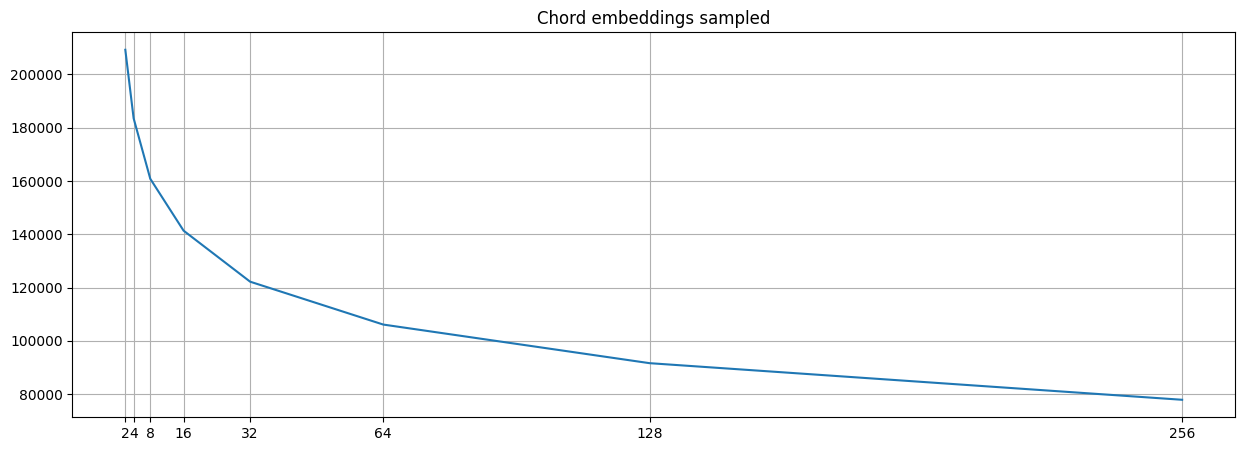

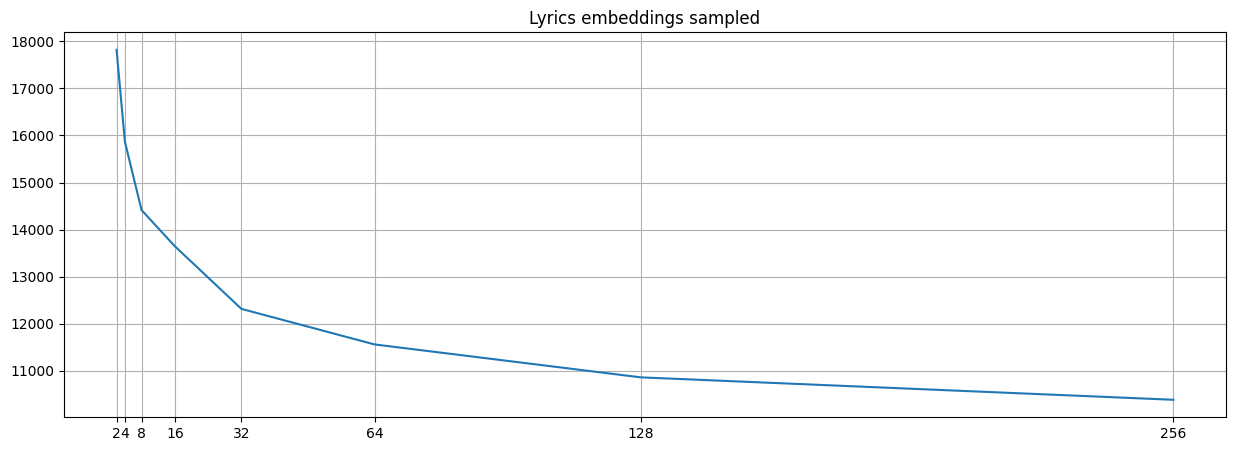

In [6]:
chords_kmeans = elbow(chords_embeddings_sampled.cpu().numpy(), [2**i for i in range(1,9)], label="Chord embeddings sampled")
lyrics_kmeans = elbow(lyrics_embeddings_sampled.cpu().numpy(), [2**i for i in range(1,9)], label="Lyrics embeddings sampled")

In [7]:
best_n_of_clusters = 16
chords_kmeans = chords_kmeans[16]
lyrics_kmeans = lyrics_kmeans[16]

chords_cluster_centers = torch.from_numpy(chords_kmeans.cluster_centers_).to(computing_device)
lyrics_cluster_centers = torch.from_numpy(lyrics_kmeans.cluster_centers_).to(computing_device)

In [ ]:
# For each cluster get the nearest and farest to the cluster centers

chord_dist = torch.cdist(chords_cluster_centers, chords_embeddings_sampled)
chords_anchors = chord_dist.argmin(dim=1).tolist()
chords_anchors = list(set(chords_anchors))

lyrics_dist = torch.cdist(lyrics_cluster_centers, lyrics_embeddings_sampled)
lyrics_anchors = lyrics_dist.argmin(dim=1).tolist()
lyrics_anchors = list(set(lyrics_anchors))

anchors_from_dataset = list(set(lyrics_anchors + chords_anchors))

lyrics_anchors_embeddings = lyrics_embeddings_sampled.to(computing_device)[anchors_from_dataset]
chord_anchors_embeddings = chords_embeddings_sampled.to(computing_device)[anchors_from_dataset]

print("number of anchors", anchors_from_dataset)

lyrics_relative_coordinates_anchors = compute_relative_coordinates(lyrics_embeddings_sampled, lyrics_anchors_embeddings, 1)
chords_relative_coordinates_anchors = compute_relative_coordinates(chords_embeddings_sampled, chord_anchors_embeddings, 1)

print(evaluate_asif(chords_relative_coordinates_anchors, lyrics_relative_coordinates_anchors, n_of_samples))
print(evaluate_asif(lyrics_relative_coordinates_anchors, chords_relative_coordinates_anchors, n_of_samples))

torch.Size([32, 768]) torch.Size([32, 256])
(272, 2)
(272, 2)
